In [ ]:

from sklearn import datasets
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA 
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from matplotlib import cm   
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import kagglehub
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [2]:

#download dataset
path = kagglehub.dataset_download("maharshipandya/-spotify-tracks-dataset")

#load CSV into a pandas dataframe
dataset = pd.read_csv(f"{path}/dataset.csv")

# see the features available
print(list(dataset.columns)) 

['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre']


In [3]:
#pre-processing

#remove duplicates, speech-like tracks and rows with missing entries
dataset = dataset.drop_duplicates(subset=["track_name", "artists"], keep="first")
dataset = dataset[dataset['speechiness'] <= 0.66]
dataset = dataset.dropna() 

#subset for selected features
selected_features = [
    'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
    'acousticness', 'instrumentalness', 'valence', 'tempo','popularity'
]

#group micro-genres into 10 macro-genres
genre_groups = {
    "pop": ['pop', 'indie-pop', 'synth-pop', 'k-pop'],
    "rock": ['rock', 'alt-rock', 'hard-rock', 'punk-rock', 'psych-rock',
             'rock-n-roll', 'grunge', 'rockabilly', 'j-rock', 'garage'],
    "electronic": ['electronic', 'electro', 'deep-house', 'techno', 'trance',
                   'minimal-techno', 'house', 'progressive-house',
                   'dubstep', 'drum-and-bass'],
    "classical": ['classical', 'opera'],
    "metal": ['metal', 'heavy-metal', 'black-metal', 'death-metal', 'metalcore'],
    "jazz": ['blues', 'soul','jazz'],
    "hip-hop": ['hip-hop'],
    "country": ['country'],
    "latin": ['latin', 'reggaeton', 'latino', 'salsa', 'tango', 'spanish'],
    "folk": ['folk', 'acoustic', 'singer-songwriter']
}

#map every micro-genre in the dataset to its macro-genre
def map_macro_genre(genre):
    for macro, subs in genre_groups.items():
        if genre in subs:
            return macro
    return None  #if not in any group, remain unmapped

#subset for selected genres
dataset['macro_genre'] = dataset['track_genre'].apply(map_macro_genre)
dataset = dataset[dataset['macro_genre'].notnull()]  #keep only mapped ones

X = dataset[selected_features].values
y = dataset['macro_genre'].values

#create labels for the genres
le = LabelEncoder()
y_id = le.fit_transform(y)
num_genres = len(le.classes_)

#display number of samples per selected genre
genre_samples_count = dataset["macro_genre"].value_counts()
print("Number of samples per genre:")
print(genre_samples_count)
print("\nTotal number of samples", len(y_id))

Number of samples per genre:
macro_genre
rock          6122
electronic    6001
metal         3742
latin         3568
pop           2324
folk          2117
classical     1567
jazz          1177
hip-hop        659
country        570
Name: count, dtype: int64

Total number of samples 27847


In [4]:

#split proportions
test_size = 0.15
val_size = 0.15

#split into train (.7) and temp (.3)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_id, test_size=(test_size + val_size), random_state=42,
)

#split temp into validation (.15) and test (.15)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=(test_size / (test_size + val_size)), random_state=42,
)

print("Train:", len(X_train))
print("Validation:", len(X_val))
print("Test:", len(X_test))



Train: 19492
Validation: 4177
Test: 4178


In [5]:
scaler=StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [6]:
#hyperparameters
embedding_dim = 5
num_epochs = 200
learning_rate = 0.00005
dropout = 0.1
batch_size = 128

#data conversion to PyTorch tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.long)
X_val = torch.tensor(X_val, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.long)

#create dataset and loader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [7]:
#genre encoder (y -> z)
class GenreEncoder(nn.Module):
    def __init__(self, num_genres, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(num_genres, embedding_dim)

    def forward(self, genre_id):
        if genre_id.dim() == 2 and genre_id.size(1) == 1:
            genre_id = genre_id.squeeze(1)
        z = self.embedding(genre_id)  # [batch, embedding_dim]
        return z

#feature encoder (x -> ẑ)
class FeatureEncoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, dropout_prob = 0.3):
        super().__init__()
        self.input = nn.Linear (input_dim, 64)
        self.hidden1 = nn.Linear (64, 64)
        self.hidden2 = nn.Linear (64, 64)
        self.out = nn.Linear (64, embedding_dim)
        self.dropout = nn.Dropout (p = dropout_prob)


    def forward(self, x):
        x = F.relu (self.input(x)); x = self.dropout(x)

        x = F.relu (self.hidden1(x)); x = self.dropout(x)

        x = F.relu (self.hidden2(x)); x = self.dropout(x)

        z_hat = self.out(x)
        return z_hat

genre_embedding = GenreEncoder(num_genres, embedding_dim)

model = FeatureEncoder(
    input_dim = X_train.shape[1], 
    embedding_dim = embedding_dim, dropout_prob = dropout
)

#loss
criterion = nn.CosineSimilarity(dim=1)

#optimizer
optimizer = optim.Adam(
    list(model.parameters()) + list(genre_embedding.parameters()),
    lr = learning_rate
)

In [8]:
model.train()
genre_embedding.train()

#embedding model training
for epoch in range(num_epochs):
    total_loss = 0.0

    for x_feat, y_genre in train_dataloader:
        optimizer.zero_grad()
        
        z_hat = F.normalize(model(x_feat), dim=1)
        z     = F.normalize(genre_embedding(y_genre), dim=1)

        cos_sim = criterion(z_hat, z)
        loss = 1 - cos_sim.mean()

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.10f}")
    

Epoch 1/200 | Loss: 0.9947642185
Epoch 2/200 | Loss: 0.6053876035
Epoch 3/200 | Loss: 0.5533227940
Epoch 4/200 | Loss: 0.5222549528
Epoch 5/200 | Loss: 0.4985565204
Epoch 6/200 | Loss: 0.4816672751
Epoch 7/200 | Loss: 0.4683687967
Epoch 8/200 | Loss: 0.4588443115
Epoch 9/200 | Loss: 0.4500933874
Epoch 10/200 | Loss: 0.4408548564
Epoch 11/200 | Loss: 0.4341461690
Epoch 12/200 | Loss: 0.4251252787
Epoch 13/200 | Loss: 0.4238972621
Epoch 14/200 | Loss: 0.4175549379
Epoch 15/200 | Loss: 0.4125987186
Epoch 16/200 | Loss: 0.4064757353
Epoch 17/200 | Loss: 0.4018061839
Epoch 18/200 | Loss: 0.3982841754
Epoch 19/200 | Loss: 0.3928483838
Epoch 20/200 | Loss: 0.3887960268
Epoch 21/200 | Loss: 0.3858375740
Epoch 22/200 | Loss: 0.3827378041
Epoch 23/200 | Loss: 0.3771819550
Epoch 24/200 | Loss: 0.3735814114
Epoch 25/200 | Loss: 0.3701688375
Epoch 26/200 | Loss: 0.3665377392
Epoch 27/200 | Loss: 0.3626498841
Epoch 28/200 | Loss: 0.3590859934
Epoch 29/200 | Loss: 0.3553990718
Epoch 30/200 | Loss: 0.


Classification Report:
              precision    recall  f1-score   support

   classical       0.90      0.69      0.78      1108
     country       0.01      0.00      0.00       401
  electronic       0.77      0.61      0.68      4217
        folk       0.16      0.66      0.26      1502
     hip-hop       0.56      0.09      0.16       482
        jazz       0.08      0.10      0.09       799
       latin       0.82      0.36      0.50      2465
       metal       0.81      0.64      0.72      2626
         pop       0.48      0.02      0.04      1643
        rock       0.47      0.52      0.50      4249

    accuracy                           0.48     19492
   macro avg       0.51      0.37      0.37     19492
weighted avg       0.60      0.48      0.49     19492


Confusion Matrix:

            rock  electronic  metal  latin  pop  folk  classical  jazz  hip-hop  country
rock        2216         149    225    103    4  1317          8   222        2        3
electronic   567   

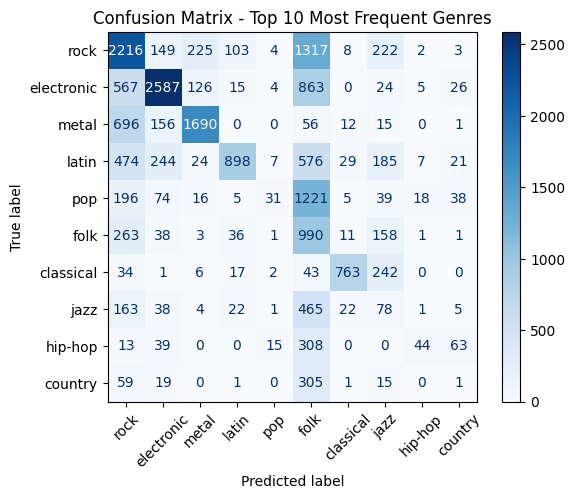

Overall model accuracy:       0.4770

Per-genre accuracy:
rock          0.5215
electronic    0.6135
metal         0.6436
latin         0.3643
pop           0.0189
folk          0.6591
classical     0.6886
jazz          0.0976
hip-hop       0.0913
country       0.0025
dtype: float64


In [10]:
#classification report

model.eval()
genre_embedding.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for x_feat, y_genre in train_dataloader: 
        #ground truth genre indices
        y_true.extend(y_genre.cpu().numpy())

        #predicted embedding from model
        z_hat = model(x_feat)

        #genre embeddings from trained embedding layer
        Z = genre_embedding.embedding.weight.data

        #cosine similarities between predicted z_hat and all genres
        cos_sim = F.cosine_similarity(
            z_hat.unsqueeze(1), Z.unsqueeze(0), dim=-1
        ) 

        #take the index of the most similar genre as prediction
        y_pred_batch = cos_sim.argmax(dim=1).cpu().numpy()
        y_pred.extend(y_pred_batch)




#classification report
classif_report = classification_report(y_true, y_pred,target_names=le.classes_)
print("\nClassification Report:")
print(classif_report)

#confusion matrix
K = 10
counts_all = pd.Series(y_true).value_counts()
topK_ids = counts_all.index[:K].to_numpy()
topK_names = le.inverse_transform(topK_ids)

#filter data
mask = np.isin(y_true, topK_ids)
y_true_top = np.array(y_true)[mask]
y_pred_top = np.array(y_pred)[mask]

cm_top = confusion_matrix(y_true_top, y_pred_top, labels=topK_ids)
cm_df = pd.DataFrame(cm_top, index=topK_names, columns=topK_names)
print("\nConfusion Matrix:\n")
with pd.option_context('display.max_columns', None, 'display.width', 200):
    print(cm_df)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_top, display_labels=topK_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Top 10 Most Frequent Genres")
plt.show()

#accuracy score for overall model
overall_acc = accuracy_score(y_true, y_pred)
print(f"Overall model accuracy:       {overall_acc:.4f}")

#per-genre accuracy (recall of each genre)
per_genre_accuracy = cm_top.diagonal() / cm_top.sum(axis=1)
acc_series = pd.Series(per_genre_accuracy, index=topK_names)
print("\nPer-genre accuracy:")
print(acc_series.round(4))

C:\Users\marta\AppData\Local\Temp\ipykernel_1040\227186161.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', K)


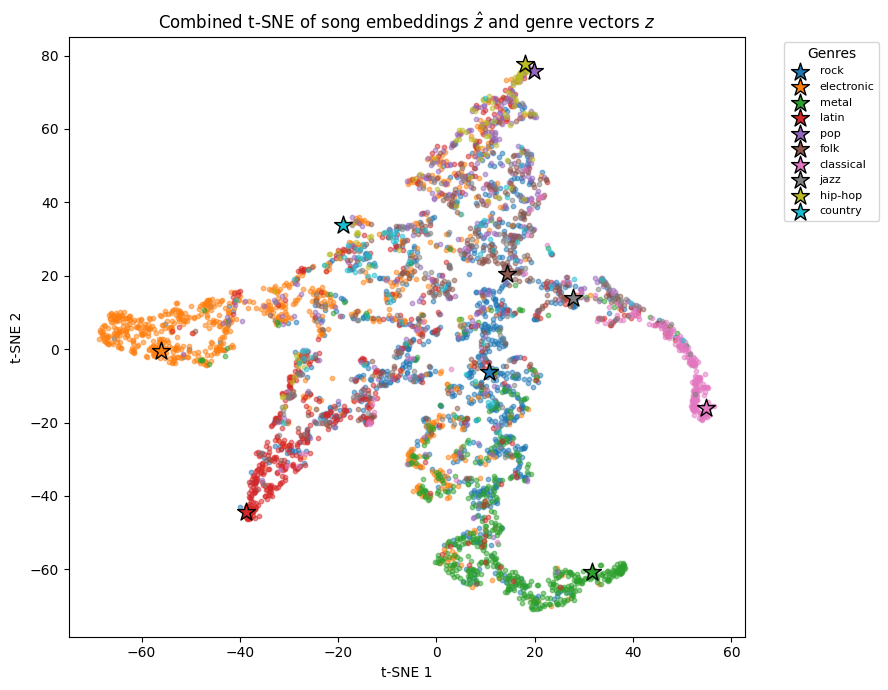

In [12]:
#visualization with t-SNE

model.eval()
genre_embedding.eval()

with torch.no_grad():
    Zhat_val = model(X_val).cpu().numpy() #song embeddings from feature encoder
    y_val_np = y_val.cpu().numpy()
    Zgenres = genre_embedding.embedding.weight.detach().cpu().numpy() #genre embeddings directly from the embedding layer

#top-K genres
K = 10
counts_all = pd.Series(y_val_np).value_counts()
topK_ids = counts_all.index[:K].to_numpy()
topK_names = le.inverse_transform(topK_ids)

#filter validation to those K
mask = np.isin(y_val_np, topK_ids)
Z = Zhat_val[mask]
y_small = y_val_np[mask]

#normalize embeddings (cosine geometry)
Zn = Z / (np.linalg.norm(Z, axis=1, keepdims=True) + 1e-12)
Zg = Zgenres / (np.linalg.norm(Zgenres, axis=1, keepdims=True) + 1e-12)

Z_combined = np.vstack([Zn, Zg[topK_ids]])
labels_combined = np.concatenate([y_small, topK_ids])  # to reuse genre colors
is_genre = np.concatenate([np.zeros(len(Zn), dtype=bool), np.ones(len(topK_ids), dtype=bool)])

# t-SNE projection
perp = 30
tsne = TSNE(
    n_components=2, perplexity=perp, learning_rate='auto',
    init='pca', metric='cosine', random_state=42
)
Z2_combined = tsne.fit_transform(Z_combined)
Z2_songs = Z2_combined[~is_genre]
Z2_genres = Z2_combined[is_genre]

#plot
plt.figure(figsize=(9,7))
cmap = cm.get_cmap('tab10', K)

#songs
for i, gid in enumerate(topK_ids):
    m = (y_small == gid)
    plt.scatter(Z2_songs[m,0], Z2_songs[m,1], s=10, color=cmap(i), alpha=0.5)

#genres
for i, gid in enumerate(topK_ids):
    plt.scatter(Z2_genres[i,0], Z2_genres[i,1], s=180, color=cmap(i),
                edgecolor='k', label=topK_names[i], marker='*')

plt.legend(title="Genres", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.title(f"Combined t-SNE of song embeddings $\\hat{{z}}$ and genre vectors $z$")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()

In [13]:
#fuzzy c-means clustering 

#extract genre embeddings after training
genre_embedding.eval()
Zgenres = genre_embedding.embedding.weight.detach().cpu().numpy()   #[num_genres, embedding_dim]

#normalize (cosine geometry)
Zg = Zgenres / (np.linalg.norm(Zgenres, axis=1, keepdims=True) + 1e-12)

c = 5       # number of broad clusters
m = 2.0      # fuzziness parameter
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    Zg.T, c=c, m=m, error=1e-6, maxiter=1000, init=None, seed=42
)
print(f"Fuzzy partition coefficient (FPC): {fpc:.3f}")

#hard cluster assignment + confidence
labels_hard = u.argmax(axis=0)    # cluster index for each genre
labels_conf = u.max(axis=0)       # highest membership value (confidence)

genre_names_all = le.classes_
df_clusters = pd.DataFrame({
    "genre": genre_names_all,
    "cluster": labels_hard,
    "membership": labels_conf
}).sort_values(["cluster", "membership"], ascending=[True, False]).reset_index(drop=True)

print("\nTop rows of fuzzy cluster mapping:")
print(df_clusters.head(110))

#map every song's genre ID to its cluster ID
cluster_of_genre = labels_hard
y_train_cluster = cluster_of_genre[y_train.cpu().numpy()]
y_val_cluster   = cluster_of_genre[y_val.cpu().numpy()]
y_test_cluster  = cluster_of_genre[y_test]

print(df_clusters['cluster'].value_counts().sort_index())


Fuzzy partition coefficient (FPC): 0.705

Top rows of fuzzy cluster mapping:
        genre  cluster  membership
0       metal        0    0.948300
1     country        1    0.990147
2   classical        2    0.999885
3         pop        3    0.962823
4     hip-hop        3    0.380772
5        folk        4    0.919423
6        rock        4    0.873656
7        jazz        4    0.828302
8  electronic        4    0.501249
9       latin        4    0.404250
cluster
0    1
1    1
2    1
3    2
4    5
Name: count, dtype: int64


C:\Users\marta\AppData\Local\Temp\ipykernel_1040\1492639749.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', c)


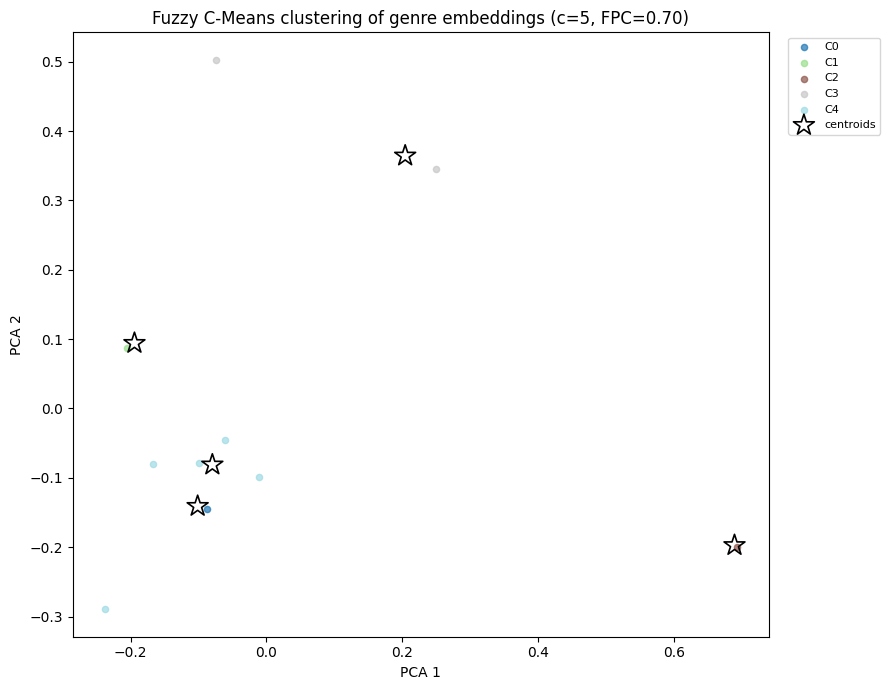

In [14]:
#visualization of fuzzy clusters

#project the genre embeddings (Zg) to 2D with PCA
pca = PCA(n_components=2, random_state=42)
Z2 = pca.fit_transform(Zg)          # shape [num_genres, 2]
C2 = pca.transform(cntr)            # cluster centers [c, 2]

plt.figure(figsize=(9,7))
cmap = plt.cm.get_cmap('tab20', c)

#plot each genre embedding colored by its hard cluster
for k in range(c):
    m = (labels_hard == k)
    plt.scatter(Z2[m,0], Z2[m,1], s=20, color=cmap(k), alpha=0.7, label=f"C{k}")

#plot cluster centroids
plt.scatter(C2[:,0], C2[:,1], s=250, marker='*', edgecolor='k', facecolor='none', linewidths=1.2, label='centroids')

plt.title(f"Fuzzy C-Means clustering of genre embeddings (c={c}, FPC={fpc:.2f})")
plt.xlabel("PCA 1"); plt.ylabel("PCA 2")
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()
